In [1]:
import os
import shutil
from PIL import Image
import pandas as pd

# convert gifs and webp

source_dir = "/kaggle/input/soil-competition-2025/soil_competition-2025/train"
dest_dir = "/tmp/train"
os.makedirs(dest_dir, exist_ok=True)

valid_exts = ('.jpg', '.jpeg', '.png')

for filename in os.listdir(source_dir):
    src_path = os.path.join(source_dir, filename)
    name_wo_ext, ext = os.path.splitext(filename)
    try:
        if ext in valid_exts:
            # copy directly for valid extensions
            shutil.copy2(src_path, os.path.join(dest_dir, filename))

        elif ext in ('.gif', '.webp'):
            # Convert to .jpg
            img = Image.open(src_path).convert("RGB")
            new_name = f"{name_wo_ext}.jpg"
            img.save(os.path.join(dest_dir, new_name))

        else:
            print(f"skip: {filename}")

    except Exception as e:
        print(f"error {filename}: {e}")

print("Cleaned folder created at:", dest_dir)


source_dir = "/kaggle/input/soil-competition-2025/soil_competition-2025/test"
dest_dir = "/tmp/test"
os.makedirs(dest_dir, exist_ok=True)


for filename in os.listdir(source_dir):
    src_path = os.path.join(source_dir, filename)
    name_wo_ext, ext = os.path.splitext(filename)

    try:
        if ext in valid_exts:
            shutil.copy2(src_path, os.path.join(dest_dir, filename))

        elif ext in ('.gif', '.webp'):
            img = Image.open(src_path).convert("RGB")
            new_name = f"{name_wo_ext}.jpg"
            img.save(os.path.join(dest_dir, new_name))

        else:
            print(f"skip: {filename}")

    except Exception as e:
        print(f"error {filename}: {e}")

print("Cleaned folder created at:", dest_dir)


Cleaned folder created at: /tmp/train
Cleaned folder created at: /tmp/test


In [2]:
df = pd.read_csv('/kaggle/input/soil-competition-2025/soil_competition-2025/train_labels.csv')        
df.head()

,image_id,label
0,img_ed005410.jpg,1
1,img_0c5ecd2a.jpg,1
2,img_ed713bb5.jpg,1
3,img_12c58874.jpg,1
4,img_eff357af.jpg,1


In [3]:
df['image_id'] = df['image_id'].str.replace(r'\.webp$', '.jpg', regex=True)
df['image_id'] = df['image_id'].str.replace(r'\.gif$', '.jpg', regex=True)

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
#train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['soil_type'], random_state=42)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
image_size = (384,384)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,

    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/tmp/train',
    x_col='image_id',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/tmp/train',
    x_col='image_id',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input',
    shuffle=True,
)

Found 977 validated image filenames.
Found 245 validated image filenames.


In [29]:
print("Class distribution in full val dataset:")
print(val_df['label'].value_counts())

Class distribution in full val dataset:
label
1    245
Name: count, dtype: int64


In [30]:
print("Class distribution in full train dataset:")
print(train_df['label'].value_counts())

Class distribution in full train dataset:
label
1    977
Name: count, dtype: int64


In [31]:
val_df.head()

,image_id,label
231,img_689f56d1.jpg,1
422,img_fb76ec77.jpg,1
43,img_34712a96.jpg,1
1007,img_009a3c89.jpg,1
552,img_0db63c5f.jpg,1


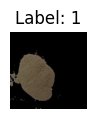

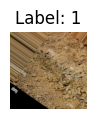

In [32]:
import matplotlib.pyplot as plt
for i in range(2):
    images, labels = next(val_generator)

# Print shapes
    #print("Image batch shape:", images.shape)
    #print("Label batch shape:", labels.shape)

# Display the first image and its label
    plt.figure(figsize=(1, 1))
    plt.imshow(images[0])
    plt.title(f"Label: {labels[0]}")
    plt.axis('off')
    plt.show()

In [67]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define image input shape
input_shape = (384, 384, 3)

# Build autoencoder
input_img = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train autoencoder
autoencoder.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)



Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 774ms/step - loss: 0.0696 - val_loss: 0.0110
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 751ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 738ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 753ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 767ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 767ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 750ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 752ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 756ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 749ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 11/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 748ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 46

In [90]:
print(reconstruction_error)

[0.00647038 0.01432712 0.00648563 0.00982832 0.00593627 0.00988821
 0.00365689 0.01065718 0.01008578 0.00919739 0.00459778 0.01002547
 0.00282565 0.01861114 0.00365474 0.01008578 0.00761685 0.00618091
 0.00439311 0.01492636 0.00648993 0.00362327 0.01278828 0.00212439
 0.00442507 0.00112715 0.00414221 0.00632919 0.04156252 0.00503061
 0.00318784 0.00406501 0.00976891 0.00609865 0.00498397 0.00828079
 0.01013616 0.00585321 0.0066917  0.00310903 0.00568869 0.00272249
 0.00445776 0.00332586 0.01331174 0.0091314  0.00109005 0.00413549
 0.04156252 0.00439311 0.00365689 0.00243979 0.00637621 0.00540162
 0.01087435 0.01198648 0.00608923 0.00091839 0.01225246 0.0101791
 0.01215674 0.00403578 0.00134413 0.01198824 0.00915487 0.00689564
 0.01854868 0.00551375 0.01126275 0.00678135 0.01010714 0.00545808
 0.01393543 0.00936825 0.01035241 0.00206703 0.00506749 0.02843335
 0.00881699 0.01828419 0.01282019 0.00093003 0.00678135 0.00723727
 0.01854868 0.01860508 0.00886577 0.0134679  0.02271297 0.02262

In [88]:
# Get all test images from generator
X_test = np.concatenate([test_generator[i] for i in range(len(test_generator))], axis=0)

# Predict reconstructions
reconstructions = autoencoder.predict(X_test)

# Compute reconstruction error per image
#reconstruction_error = np.mean((X_test - reconstructions) ** 2, axis=(1, 2, 3))
reconstruction_error = np.mean((X_test - reconstructions) ** 2, axis=(1, 2, 3))

# Set threshold (e.g., 95th percentile of errors)
#threshold = np.percentile(reconstruction_error, 99.999)

#  Assign label: 1 = normal, 0 = anomaly
#pred_labels = (reconstruction_error < threshold).astype(int)
pred_labels = (reconstruction_error > 0.0016).astype(int)
test_df['label'] = (pred_labels)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step


In [84]:
test_df.tail(15)

,image_id,label
952,785c829fbdf45a0cbd1af3a462e122be.jpg,0
953,330d490214285279b81451accfcfc60a.jpg,1
954,71696a0d5fac5a04a7530693470ff66b.jpg,1
955,a42f915e725c52ccbd1a89ac3e850ead.jpg,1
956,a19f8fc9d56f5bcd9809090d87b6a8e4.jpg,1
957,bfa1bdb23de95b038e01f78cca5f4515.jpg,0
958,022fa6c0e0af5aa8af770e1a5927f993.jpg,1
959,06a694a51b035d4aa1a69aea26061df4.jpg,0
960,fa6c9fd264dd506d935ca5d4a7bc6aff.jpg,0
961,4cd11d3ad15d551187262dd75f936e80.jpg,0


In [89]:
test_df.head()

,image_id,label
0,6595f1266325552489c7d1635fafb88f.jpg,1
1,4b614841803d5448b59e2c6ca74ea664.jpg,1
2,ca30e008692a50638b43d944f46245c8.jpg,1
3,6a9046a219425f7599729be627df1c1a.jpg,1
4,97c1e0276d2d5c2f88dddbc87357611e.jpg,1


In [85]:
test_df.to_csv('submission.csv', index=False)

In [82]:
test_df = pd.read_csv("/kaggle/input/soil-competition-2025/soil_competition-2025/test_ids.csv")
test_df['image_id'] = test_df['image_id'].str.replace(r'\.webp$', '.jpg', regex=True)
test_df['image_id'] = test_df['image_id'].str.replace(r'\.gif$', '.jpg', regex=True)
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/tmp/test',
    x_col='image_id',
    y_col=None,
    target_size=image_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

predictions = model.predict(test_generator, verbose=1)


# Attach predictions to filenames
test_df['label'] = (predictions > 0.10).astype(int)

test_df.to_csv('submission.csv', index=False)
test_df.tail()

Found 967 validated image filenames.
  9/967 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


967/967 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


,image_id,label
962,0a7bf5babc365ca6b10dae582661988e.jpg,1
963,1bd2aef3edff5434891801e77975f533.jpg,1
964,86522810b6045b2f9ccdb2f9027aadf8.jpg,1
965,687517ac929e59428f0c20de4a994b5f.jpg,1
966,3325701afb3b52e1871d401e2a3cf0a3.jpg,1
